# SECOM 異常偵測：真實資料 + Isolation Forest & AutoEncoder

# 🔍 04 - SECOM 異常偵測：Isolation Forest vs AutoEncoder

本 Notebook 針對 SECOM 製造資料集進行異常偵測任務，使用兩種方法：
- ✅ Isolation Forest（Unsupervised）
- ✅ AutoEncoder（Semi-Supervised）

並評估兩者的預測效果、混淆矩陣與異常分數分布，以驗證其適用性。

📦 資料說明：
- 來自 SECOM 半導體製程設備的感測器數據
- 標籤 1 表示異常（Fault），-1 表示正常（Non-Fault）
- 嚴重類別不平衡問題（異常樣本極少）

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns



## Step 1: 載入資料與標籤
- 載入 SECOM 感測器資料與標籤
- 標籤轉換為 0（正常）與 1（異常）

In [2]:
# 載入資料
secom_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', header=None, delim_whitespace=True)
secom_data.columns = [f"sensor_{i+1}" for i in range(secom_data.shape[1])]

secom_labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', header=None, delim_whitespace=True)
secom_labels.columns = ["label", "timestamp"]
print(secom_labels["label"].value_counts())



# 分離特徵與標籤
X = secom_data
y = (secom_labels["label"] == 1).astype(int)




label
-1    1463
 1     104
Name: count, dtype: int64


/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_29060/2905608231.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  secom_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', header=None, delim_whitespace=True)
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_29060/2905608231.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  secom_labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', header=None, delim_whitespace=True)


## Step 2: 訓練 / 測試資料分割與標準化
- 使用 Stratified Split 維持類別比例
- 套用自訂 Preprocessor 進行填補與標準化
- 支援 SMOTEENN 作為進階不平衡處理（預留）

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent.parent  # 根據你的資料夾結構調整
print(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))
from preprocessing.secom_preprocessor import Preprocessor
from preprocessing.balancer import apply_smoteenn
pre = Preprocessor()
X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)


# X_train_proc,y_train = apply_smoteenn(X_train_proc, y_train, random_state=42)

/Users/ching/Documents/SideProject/industrial-fault-prediction
▶ Imputing missing values with mean...
▶ Handling outliers using IQR clipping...
▶ Removing near-zero variance features...
✅ Remaining features after variance filter: 590
▶ Removing highly correlated features (Pearson > 0.95)...
✅ Remaining features after correlation filter: 590
▶ Scaling features...


## Step 3: 使用 Isolation Forest 預測異常
- 訓練 IF 模型，輸出 -1/1 轉換為 binary 預測
- 輸出分類報告與 ROC AUC 分數
- 畫出混淆矩陣與異常樣本判斷結果

📊 Isolation Forest 結果：
              precision    recall  f1-score   support

   Non-Fault       0.93      0.91      0.92       293
       Fault       0.07      0.10      0.08        21

    accuracy                           0.86       314
   macro avg       0.50      0.50      0.50       314
weighted avg       0.88      0.86      0.87       314

ROC AUC: 0.5032504469364538


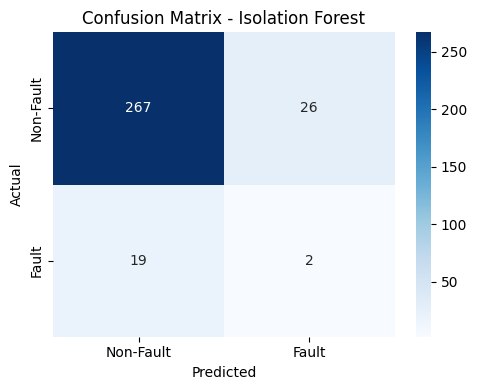

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Isolation Forest ----------- #
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_train_proc)
y_pred_if = (iso.predict(X_test_proc) == -1).astype(int)

print("📊 Isolation Forest 結果：")
print(classification_report(y_test, y_pred_if, target_names=["Non-Fault", "Fault"]))
print("ROC AUC:", roc_auc_score(y_test, y_pred_if))

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_if)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-Fault", "Fault"],
            yticklabels=["Non-Fault", "Fault"])
plt.title("Confusion Matrix - Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Step 4: 使用 AutoEncoder 預測異常
- 僅使用正常樣本訓練重建模型
- 比較測試資料與重建資料的誤差（MSE）
- 計算重建誤差分布，以 95% 分位數作為判斷閾值
- 輸出分類報告與 ROC AUC，畫出混淆矩陣
- 額外視覺化：正常 vs. 異常重建誤差分布圖

2025-05-29 14:52:31.746956: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-29 14:52:31.746999: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-29 14:52:31.747011: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1748501551.747029  557515 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748501551.747060  557515 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-29 14:52:32.096262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 AutoEncoder 結果：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.95      0.94       293
       Fault       0.17      0.14      0.15        21

    accuracy                           0.89       314
   macro avg       0.55      0.55      0.55       314
weighted avg       0.89      0.89      0.89       314

ROC AUC: 0.5458313018039981


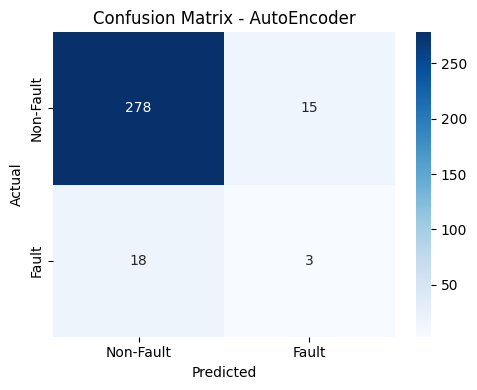

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------- AutoEncoder ----------- #
X_train_normal = X_train_proc[y_train.values == 0]

input_dim = X_train_normal.shape[1]
inputs = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(inputs)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_normal, X_train_normal, epochs=30, batch_size=32, verbose=0)

# 預測 + 判斷異常
X_test_pred = autoencoder.predict(X_test_proc)
reconstruction_error = np.mean(np.square(X_test_proc - X_test_pred), axis=1)

# 以正常樣本的 95% 分位數當作 threshold
threshold = np.percentile(reconstruction_error[np.array(y_test) == 0], 95)
y_pred_ae = (reconstruction_error > threshold).astype(int)

# 結果輸出
print("📊 AutoEncoder 結果：")
print(classification_report(y_test, y_pred_ae, target_names=["Non-Fault", "Fault"]))
print("ROC AUC:", roc_auc_score(y_test, y_pred_ae))

# 混淆矩陣圖
cm = confusion_matrix(y_test, y_pred_ae)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-Fault", "Fault"],
            yticklabels=["Non-Fault", "Fault"])
plt.title("Confusion Matrix - AutoEncoder")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

##### 畫圖：重建誤差分布（正常 vs 異常）

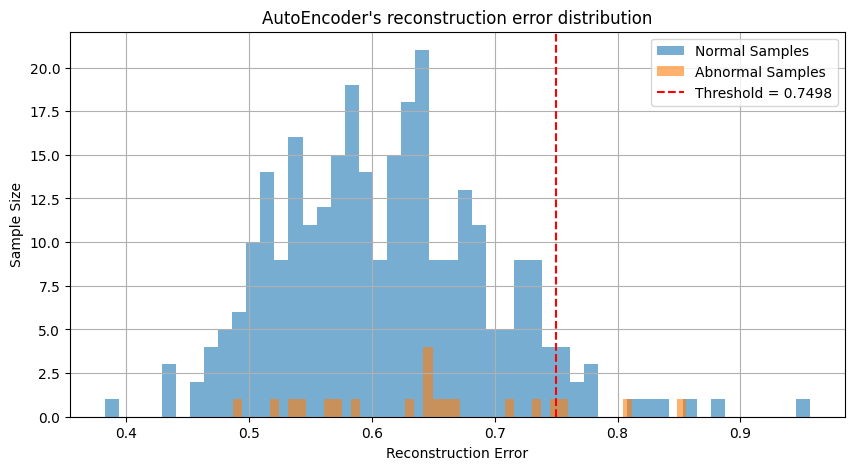

In [7]:
import matplotlib.pyplot as plt

# 確保 y_test 是 numpy 陣列（避免 index 不齊）
y_test_array = np.array(y_test)

plt.figure(figsize=(10,5))
plt.hist(reconstruction_error[y_test_array == 0], bins=50, alpha=0.6, label="Normal Samples")
plt.hist(reconstruction_error[y_test_array == 1], bins=50, alpha=0.6, label="Abnormal Samples")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title("AutoEncoder's reconstruction error distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Sample Size")
plt.legend()
plt.grid(True)
plt.show()

#### 強化 AutoEncoder：多層 + Dropout（更深的神經網路）

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
📊 AutoEncoder 結果：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.95      0.94       293
       Fault       0.12      0.10      0.11        21

    accuracy                           0.89       314
   macro avg       0.53      0.52      0.52       314
weighted avg       0.88      0.89      0.89       314

ROC AUC: 0.5220217779944742


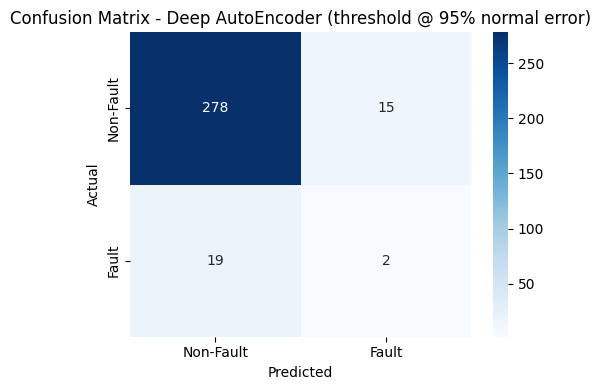

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 建立 AutoEncoder 模型
input_dim = X_train_normal.shape[1]
inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
decoded = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, verbose=0)

# 預測 + 重建誤差判斷異常
X_test_pred = autoencoder.predict(X_test_proc)
reconstruction_error = np.mean(np.square(X_test_proc - X_test_pred), axis=1)

# 使用正常樣本的 95% 分位數當作 threshold
threshold = np.percentile(reconstruction_error[np.array(y_test) == 0], 95)
y_pred_ae = (reconstruction_error > threshold).astype(int)

# 評估
print("📊 AutoEncoder 結果：")
print(classification_report(y_test, y_pred_ae, target_names=["Non-Fault", "Fault"]))
print("ROC AUC:", roc_auc_score(y_test, y_pred_ae))

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_ae)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-Fault", "Fault"],
            yticklabels=["Non-Fault", "Fault"])
plt.title("Confusion Matrix - Deep AutoEncoder (threshold @ 95% normal error)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# # =======================
# # 1️⃣ 讀取 & 前處理 SECOM 資料
# # =======================


# 分出 "正常樣本" 訓練 AutoEncoder
X_train_normal = X_train_proc[y_train.values == 0]


# =======================
# 2️⃣ 建立 AutoEncoder 模型
# =======================
input_dim = X_train_proc.shape[1]

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation="relu")(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(64, activation="relu")(encoded)
encoded = Dense(32, activation="relu")(encoded)
latent = Dense(16, activation="relu", name="latent")(encoded)

# Decoder
decoded = Dense(32, activation="relu")(latent)
decoded = Dense(64, activation="relu")(decoded)
decoded = Dense(128, activation="relu")(decoded)
decoded = Dense(input_dim, activation="linear")(decoded)

# 自動編碼器
autoencoder = Model(input_layer, decoded, name="AutoEncoder")

# =======================
# 3️⃣ 建立分類器 (基於 Latent Representation)
# =======================
clf_hidden = Dense(16, activation="relu")(latent)
clf_hidden = Dropout(0.2)(clf_hidden)
clf_output = Dense(1, activation="sigmoid", name="classifier_output")(clf_hidden)

classifier = Model(input_layer, clf_output, name="Classifier")

# =======================
# 4️⃣ 損失函數：AutoEncoder + Classifier
# =======================
mse_loss = MeanSquaredError()
bce_loss = BinaryCrossentropy()

def custom_loss(y_true, y_pred):
    """ 結合 MSE (AutoEncoder) + Binary Crossentropy (Classifier) """
    rec_target, label = y_true[:, :-1], y_true[:, -1:]
    rec_output, class_output = y_pred[:, :-1], y_pred[:, -1:]


    rec_loss = mse_loss(rec_target, rec_output)
    clf_loss = bce_loss(label, class_output)
    
    alpha = 0.5  # 控制分類器的重要性
    return rec_loss + alpha * clf_loss

# =======================
# 5️⃣ 建立 & 編譯整合模型
# =======================
combined_output = tf.keras.layers.concatenate([decoded, clf_output])
full_model = Model(input_layer, combined_output, name="AE_Classifier")

full_model.compile(optimizer=Adam(0.001), loss=custom_loss)

# =======================
# 6️⃣ 訓練 AutoEncoder + 分類器
# =======================
# 構造訓練標籤（AE 輸出 + 分類器標籤）

y_train_combined = np.hstack([X_train_proc, y_train.values.reshape(-1, 1)])
y_test_combined = np.hstack([X_test_proc, y_test.values.reshape(-1, 1)])

full_model.fit(X_train_proc, y_train_combined, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_proc, y_test_combined))

# =======================
# 7️⃣ 預測與評估
# =======================
# 分離 AutoEncoder 和 Classifier 的輸出
y_test_pred = full_model.predict(X_test_proc)
X_test_reconstructed = y_test_pred[:, :-1]
y_pred_proba = y_test_pred[:, -1]  # 分類器的預測機率

# 重建誤差
reconstruction_error = np.mean(np.square(X_test_proc - X_test_reconstructed), axis=1)

# 設定異常閾值（取正常樣本的 95% 分位）
threshold = np.percentile(reconstruction_error[np.array(y_test) == 0], 95)
y_pred_ae = (reconstruction_error > threshold).astype(int)

# 計算分類器的預測結果
y_pred_clf = (y_pred_proba > 0.5).astype(int)



Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1.8736 - val_loss: 1.2284
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.4728 - val_loss: 1.2990
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 2.8401 - val_loss: 3.1975
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 6.8531 - val_loss: 30.4082
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 32.7762 - val_loss: 104.8335
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 101.6169 - val_loss: 157.3307
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 124.5204 - val_loss: 831.9429
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 4039.5708 - val_loss: 129154.8047
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 507514.5000 - val_loss: 18770510.0000
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 42519768.0000 - val_loss: 1608501120.0000
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 1007808000.0000 - val_loss: 10

📊 AutoEncoder 結果（重建誤差）：
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       293
           1       0.12      0.10      0.11        21

    accuracy                           0.89       314
   macro avg       0.53      0.52      0.52       314
weighted avg       0.88      0.89      0.89       314

ROC AUC: 0.5220217779944742


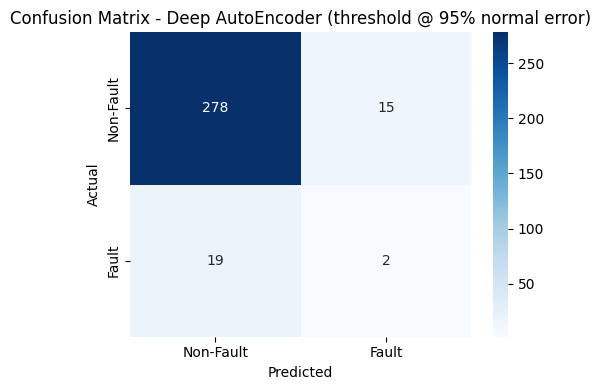


📊 分類器結果（Latent representation）：
              precision    recall  f1-score   support

           0       0.97      0.57      0.71       293
           1       0.11      0.71      0.18        21

    accuracy                           0.58       314
   macro avg       0.54      0.64      0.45       314
weighted avg       0.91      0.58      0.68       314

ROC AUC: 0.6404193076548026


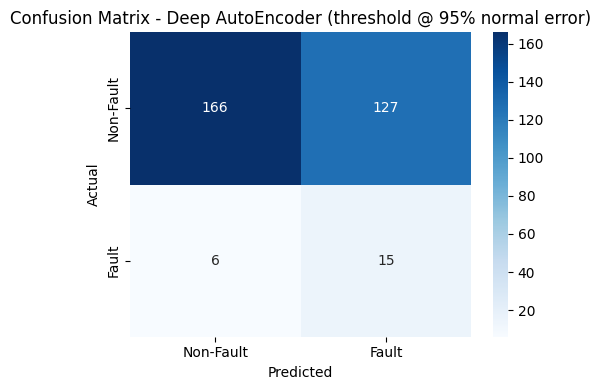

In [10]:

# =======================
# 8️⃣ 評估結果
# =======================
print("📊 AutoEncoder 結果（重建誤差）：")
print(classification_report(y_test, y_pred_ae))
print("ROC AUC:", roc_auc_score(y_test, y_pred_ae))


# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_ae)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-Fault", "Fault"],
            yticklabels=["Non-Fault", "Fault"])
plt.title("Confusion Matrix - Deep AutoEncoder (threshold @ 95% normal error)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


print("\n📊 分類器結果（Latent representation）：")
print(classification_report(y_test, y_pred_clf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_clf))


# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_clf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-Fault", "Fault"],
            yticklabels=["Non-Fault", "Fault"])
plt.title("Confusion Matrix - Deep AutoEncoder (threshold @ 95% normal error)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()